In [ ]:
import os
import pyciemss
import torch
import pandas as pd
import numpy as np
from typing import Dict, List, Callable

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

smoke_test = ('CI' in os.environ)

In [ ]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type2_petrinet.json")
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
dataset2 = os.path.join(DATA_PATH, "traditional.csv")

In [ ]:
start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_samples = 3 if smoke_test else 100

In [ ]:
data_mapping = {"case": "infected", "hosp": "hospitalized"} # data is mapped to observables
# data_mapping = {"case": "I", "hosp": "H"} # data is mapped to state variables

num_iterations = 10 if smoke_test else 1000
calibrated_results = pyciemss.calibrate(model1, dataset1, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
calibrated_results

/Users/cott741/projects/ASKEM/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 2 rows of data. The first column, Timestamp, begins at 1.1 and ends at 3.3. The subsequent columns are named: case, hosp


{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 14.902970284223557}

In [ ]:
parameter_estimates()

{'persistent_beta_c': tensor(0.1092, grad_fn=<ExpandBackward0>),
 'persistent_kappa': tensor(0.6172, grad_fn=<ExpandBackward0>),
 'persistent_gamma': tensor(0.3740, grad_fn=<ExpandBackward0>),
 'persistent_hosp': tensor(0.1468, grad_fn=<ExpandBackward0>),
 'persistent_death_hosp': tensor(0.0195, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(8.1013, grad_fn=<ExpandBackward0>)}

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,persistent_beta_s_param,...,S_state,I_state,E_state,R_state,H_state,D_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,0.0,0.673329,0.558652,0.375207,0.144439,0.055512,8.411292,1.0,...,19339992.0,8.411292,40.000000,0.000000,0.000000,0.000000,8.411292,40.000000,0.000000,0.000000
1,1,0,10.0,0.673329,0.558652,0.375207,0.144439,0.055512,8.411292,1.0,...,19339868.0,32.417866,57.278103,78.082779,6.015589,0.343126,32.417866,57.278103,6.015589,0.343126
2,2,0,20.0,0.673329,0.558652,0.375207,0.144439,0.055512,8.411292,1.0,...,19339612.0,62.936996,111.152405,242.977997,12.728435,1.354570,62.936996,111.152405,12.728435,1.354570
3,3,0,30.0,0.673329,0.558652,0.375207,0.144439,0.055512,8.411292,1.0,...,19339114.0,122.152931,215.730865,563.892334,24.847301,3.368282,122.152931,215.730865,24.847301,3.368282
4,4,0,40.0,0.673329,0.558652,0.375207,0.144439,0.055512,8.411292,1.0,...,19338128.0,237.068848,418.673035,1186.845947,48.243042,7.283447,237.068848,418.673035,48.243042,7.283447


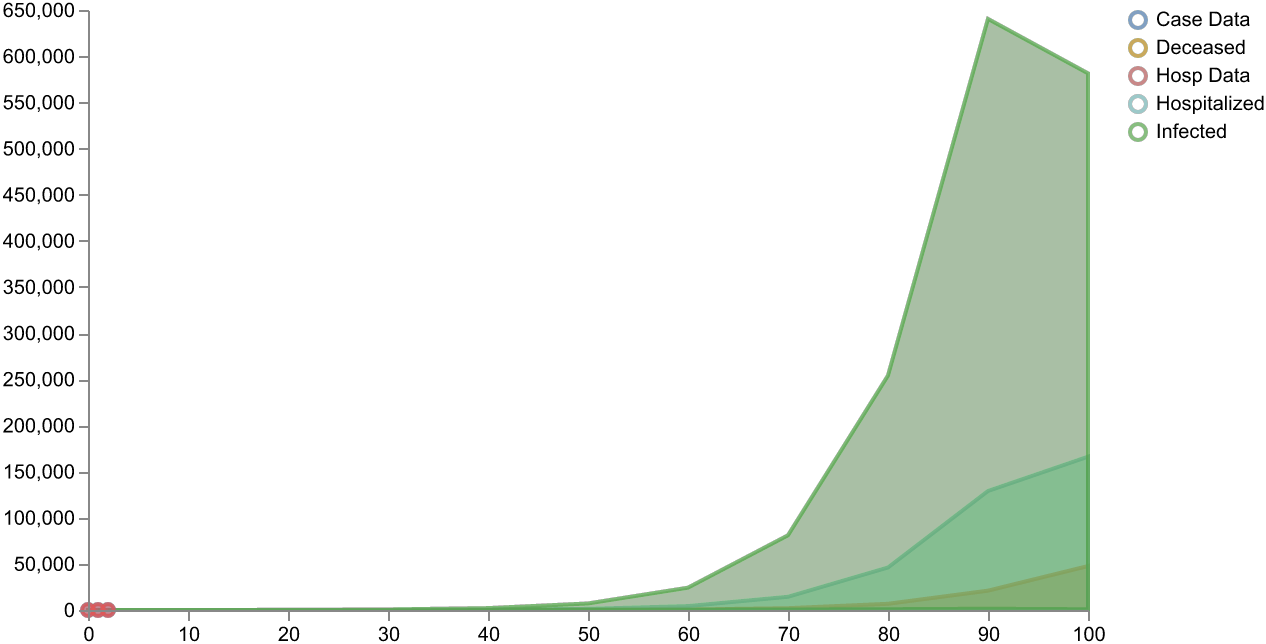

In [ ]:
calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "dead_observable_state": "Deceased", 
        "hospitalized_observable_state": "Hospitalized",
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data",
        "hosp": "Hosp Data"
        }
data_df = pd.read_csv(dataset1)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state", "hospitalized_observable_state", "dead_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Shapley Values: How important were details *in the calibrated model*

In [ ]:
import random

def choose(values):
    return lambda: random.choice(values)

def discretized(*, n, center, step):
    """Create a sequence of n sample points centered on center the given step-size"""
    low = [*reversed([center-(step*i) for i in range(1, n+1)])]
    high = [center+(step*i) for i in range(n+1)]
    steps = low + high
    return lambda: random.choice(steps)

f = discretized(n=2, center=5, step=1)

In [ ]:
class RandomCombination:
    def __init__(self, target_inputs):
        self.target_inputs = target_inputs
        
    def __next__(self):
        return {var: torch.tensor(strategy()) for var, strategy in self.target_inputs}

In [ ]:
import itertools
import tqdm
from datetime import datetime


def shapley(calibrated_model, parameter_estimates, players, payout, *, budget=1000):
    """
    calibrated_model -- Model that has been calibrated to an objective function
    parameter_estimates -- Full set of calibrated inputs
    players -- Tripples of (input var name, sampling strategy, output var name)
    payout -- Which *single* output parameter is of interest?

    #TODO: Make 'payout' a function fo the result (not just a single column)

    budget -- Number of seconds to keep sampling
    """

    progress = tqdm.tqdm(desc="Shapley sample 0", total=budget, unit="seconds")


    input_gen = RandomCombination([p[:2] for p in players])
    output_names = [p[2] for p in players] + [payout]
    observations = []

    start = datetime.now()


    for i in itertools.count():
        test_intervention = {torch.tensor(0): next(input_gen)}
        progress.set_description(f"Shapley sample {i+1}")
        test_results = pyciemss.sample(calibrated_model, 
                                       end_time, 
                                       logging_step_size, 
                                       num_samples, 
                                       start_time=start_time, 
                                       inferred_parameters=parameter_estimates, 
                                       static_parameter_interventions=test_intervention
                                       )
        
        observations.append(test_results["data"][output_names])


        elapse = (datetime.now()-start).total_seconds()
        progress.update(elapse-progress.n)
        if elapse > budget:
            break

    progress.close()
    progress.set_description(f"Stopped after {i} samples and {elapse} seconds")
    return observations

    #generate sequence of

kappa_fn = discretized(n=5, center=parameter_estimates()["persistent_kappa"].item(), step=.001)
gamma_fn = discretized(n=5, center=parameter_estimates()["persistent_gamma"].item(), step=.001)
players = [("kappa", kappa_fn, "persistent_kappa_param"),
           ("gamma", gamma_fn, "persistent_gamma_param")]
payout = "hospitalized_observable_state"
observations = shapley(model1, 
                 parameter_estimates, 
                 players,
                 payout,
                 budget=5)













































Shapley sample 5: : 6.229357seconds [00:06,  1.00s/seconds]


In [ ]:
def average_marginal_contribution(baseline, observations, players, payout):
    def znorm(s): return (s-s.mean())/s.std()

    input_names = [p[2] for p in players]

    deltas = [obs-baseline[obs.columns] for obs in observations]
    deltas = pd.concat(observations).reset_index(drop=False, names="time").join(pd.concat(deltas).reset_index(drop=True), rsuffix="_delta")
    fine = {name: deltas.groupby(f"{name}_delta")[f"{payout}_delta"].mean() for name in input_names}
    fine_norm = {name: znorm(value) for name, value in fine.items()}
    coarse = {name: value.mean() for name, value in fine.items()}
    coarse_norm = {name: value.mean() for name, value in fine_norm.items()}
        
    return fine, fine_norm, coarse, coarse_norm

fine, fine_norm, coarse, coarse_norm = average_marginal_contribution(calibrated_sample_results["data"], observations, players, payout)

In [ ]:
coarse_norm

{'persistent_kappa_param': 7.105427357601002e-17,
 'persistent_gamma_param': 0.0}